In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import joblib

from forecasting_bluesky_code import preprocessing as pre
from forecasting_bluesky_code import impact_score as isc
from forecasting_bluesky_code import metrics_plots as mp


# Linear Regression: daily new users
Objetivo: predecir nuevos usuarios de mañana. Usamos el dataset diario, es decir, con un registro por cada día desde 2023-05-08.

### Dataset diario
Preparamos el dataset de datos diarios.

In [5]:
df = pd.read_csv('final_dataset_bsky_news.csv')

In [6]:
df = pre.basic_proc_final_dataset(df)

In [7]:
df.columns

Index(['artificial intelligence', 'crime', 'education', 'elections',
       'entertainment', 'environment', 'finance', 'health', 'immigration',
       'international relations', 'pandemics', 'politics', 'protests',
       'science', 'sports', 'technology', 'videogames', 'war', 'tot_users',
       'new_users', 'num_likes', 'num_posts', 'num_images', 'num_follows',
       'num_blocks'],
      dtype='object')

In [8]:
# Separamos las columnas de texto para aplicarles el impact_score
df_text = df.drop(columns = df._get_numeric_data().columns)

# Separamos las columnas que serán el resto de features del modelo
df_ft = df.drop(columns = df_text.columns)

In [9]:
df_text.columns, df_ft.columns

(Index(['artificial intelligence', 'crime', 'education', 'elections',
        'entertainment', 'environment', 'finance', 'health', 'immigration',
        'international relations', 'pandemics', 'politics', 'protests',
        'science', 'sports', 'technology', 'videogames', 'war'],
       dtype='object'),
 Index(['tot_users', 'new_users', 'num_likes', 'num_posts', 'num_images',
        'num_follows', 'num_blocks'],
       dtype='object'))

### Feature Engineering para datos continuos
- Nuevos usuarios diarios
- Agregado de total de usuarios diario
- PCA para las columnas de actividad.
- Series temporales: Lags (yesterday data for users, new users and activity score), Rolling Mean (7 day rolling mean data for new users and activity score), Diff.

In [11]:
df_ft = pre.activity_score_pca(df_ft)
df_ft = pre.temp_columns(df_ft, window = 4)
#df = pre.standard_scaler_num(df)

### Impact Score para las noticias
Sacamos el impact score de las noticias de 2025 para usarlo como una feature más del modelo.

In [ ]:
# 1. Pipeline para aplicar los diferentes componentes (solo 2025)
df_text_2025 = df_text.loc['01-01-2025':,:]
impact_score_array = isc.impact_score_pipeline.fit_transform(df_text_2025)

In [ ]:
# 2. Cargamos el modelo XGBoost pre-entrenado
xgb_model = joblib.load('impact_score_xgb_model.pkl')

In [13]:
# 3. Sacamos el impact_score de las noticias de 2025
impact_score_2025 = xgb_model.predict_proba(df_text_2025)[:,1]

In [14]:
# Unimos esta nueva feature al resto del dataframe

# Crear rango de fechas para el array actual
start_2025 = pd.to_datetime('2025-01-01')
end_2025 = pd.to_datetime('2025-04-07')
dates_2025 = pd.date_range(start=start_2025, end=end_2025)

# Crear el DataFrame con los datos
df_2025 = pd.DataFrame(data=impact_score_2025, index=dates_2025, columns=['impact_score'])

# Crear rango de fechas faltante (desde 2023-05-08 hasta 2024-12-31)
dates_missing = pd.date_range(start='2023-05-08', end='2024-12-31')
df_missing = pd.DataFrame(0, index=dates_missing, columns=['impact_score'])

# Concatenar ambos DataFrames
df_impact_score_2025 = pd.concat([df_missing, df_2025])

# Verificamos que todo esté ordenado por fecha
df_impact_score_2025 = df_impact_score_2025.sort_index()

In [15]:
# Concatenamos con el df completo
df_final = pd.concat([df_ft, df_impact_score_2025], axis = 1)

In [16]:
df_final

,tot_users,new_users,activity_score_pca,users_lag1,new_users_lag1,activity_lag1,new_users_ma7,activity_ma7,new_users_diff,activity_diff,impact_score
2023-05-08,31522.0,0.0,-1.650371,0.0,0.0,0.000000,0.000,0.000000,0.0,0.000000,0.000000
2023-05-09,33644.5,2122.5,-1.644322,31522.0,0.0,-1.650371,0.000,0.000000,2122.5,0.006049,0.000000
2023-05-10,35767.0,2122.5,-1.647769,33644.5,2122.5,-1.644322,0.000,0.000000,0.0,-0.003446,0.000000
2023-05-11,37889.5,2122.5,-1.649415,35767.0,2122.5,-1.647769,1591.875,-1.647969,0.0,-0.001646,0.000000
2023-05-12,40012.0,2122.5,-1.646652,37889.5,2122.5,-1.649415,2122.500,-1.647039,0.0,0.002763,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2025-04-03,33995137.0,90941.0,2.993873,33904196.0,47100.0,2.729988,52978.500,2.662422,43841.0,0.263885,0.509488
2025-04-04,34177832.0,182695.0,3.828071,33995137.0,90941.0,2.993873,89824.750,3.012377,91754.0,0.834198,0.082880
2025-04-05,34320771.0,142939.0,3.598483,34177832.0,182695.0,3.828071,115918.750,3.287604,-39756.0,-0.229588,0.583130
2025-04-06,34452077.0,131306.0,3.601917,34320771.0,142939.0,3.598483,136970.250,3.505586,-11633.0,0.003433,0.119040


### Target: mañana
Nuestro objetivo es predecir los nuevos usuarios que habrá mañana

In [18]:
df_final['target'] = df_final['new_users'].shift(-1)
df_final = df_final.fillna(0)

In [19]:
# Target
target = 'target'

# X y division
X = df_final.drop(columns=target)
y = df_final[target]

### Features finales del modelo
- **tot_users**: el total de usuarios agregado por día
- **new_users**: el total de nuevos usuarios diario
- **activity_score_pca**: principal components analysis (score de -1.7 a 8.7)
- **Impact Score**: impacto de las noticias en el crecimiento de la actividad en la red
- **Target**: nuevos usuarios del día siguiente

#### Exportar datos

In [71]:
df_final.to_csv('daily_dataset_model_features_reg.csv')

## Regression Model

#### Train-Test Split
Se hace manteniendo la temporalidad de los datos, sin shuffle.

In [23]:
total_reg = len(df_final.index)
test_size_reg = 0.15

total_test = round(total_reg*test_size_reg)
total_train = total_reg-total_test

total_test, total_train

(105, 596)

Fechas train : 2023-05-08 00:00:00 --- 2024-12-23 00:00:00  (n=596)
Fechas test  : 2024-12-24 00:00:00 --- 2025-04-07 00:00:00  (n=105)


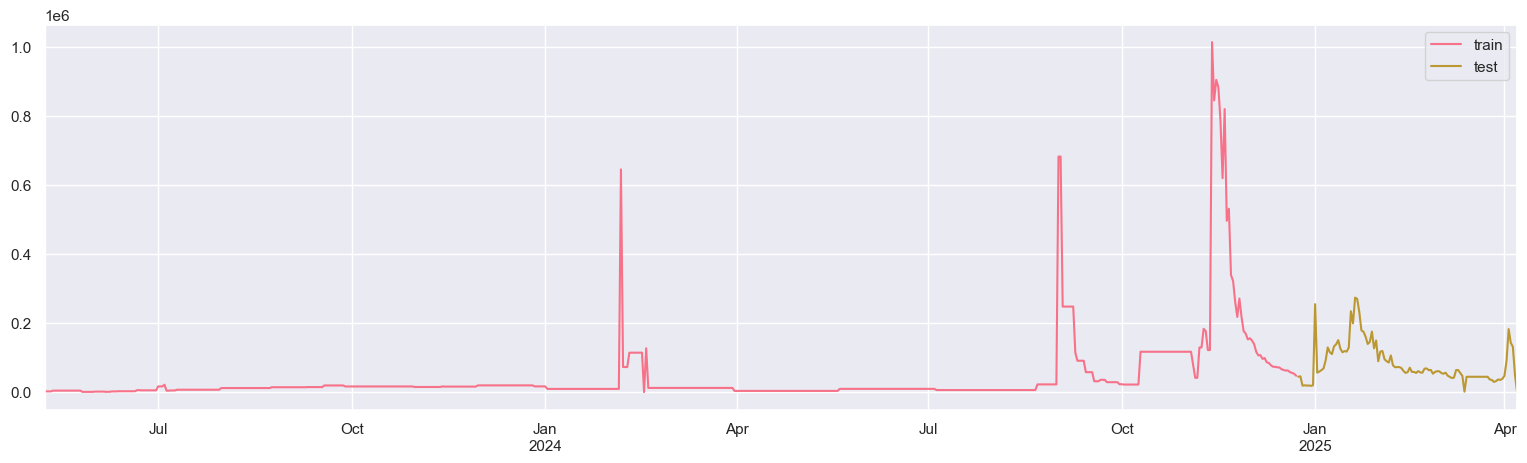

In [24]:
# Separación datos train-test
# Se usan los últimos *total_test días para testear el modelo
# ==============================================================================
steps = total_test
datos_train = df_final[:-steps]
datos_test  = df_final[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(19, 5))
datos_train[target].plot(ax=ax, label='train')
datos_test[target].plot(ax=ax, label='test')
ax.legend();
plt.savefig('train-test-linear-daily.png')
plt.show()

In [25]:
X_train = datos_train.drop(columns = target)
y_train = datos_train[target]

X_test = datos_test.drop(columns = target)
y_test = datos_test[target]

#### LinearRegression

In [27]:
# Definición del modelo
model = LinearRegression()

# Escalado de datos
scaler = StandardScaler()

pipeline = Pipeline([
    ('scaler', scaler),
    ('model', model)
])

In [28]:
pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [29]:
# Entrenamos el modelo
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [30]:
# Predicciones sobre el conjunto de train
y_pred_train = pipeline.predict(X_train)
# Predicciones sobre el conjunto de prueba
y_pred = pipeline.predict(X_test)

# Evaluar el modelo train
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
rmse = np.sqrt(mse)

print('TRAIN')
print(f"  MSE: {mse:.2f}")
print(f"  R²: {r2:.2f}")
print(f"  RMSE: {rmse:.2f}")

# Evaluar el modelo test
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print('TEST')
print(f"  MSE: {mse:.2f}")
print(f"  R²: {r2:.2f}")
print(f"  RMSE: {rmse:.2f}")

TRAIN
  MSE: 3526004337.32
  R²: 0.72
  RMSE: 59380.17
TEST
  MSE: 1288143016.73
  R²: 0.61
  RMSE: 35890.71


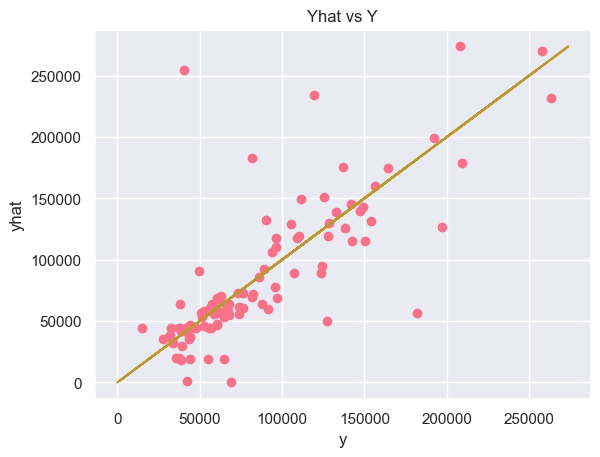

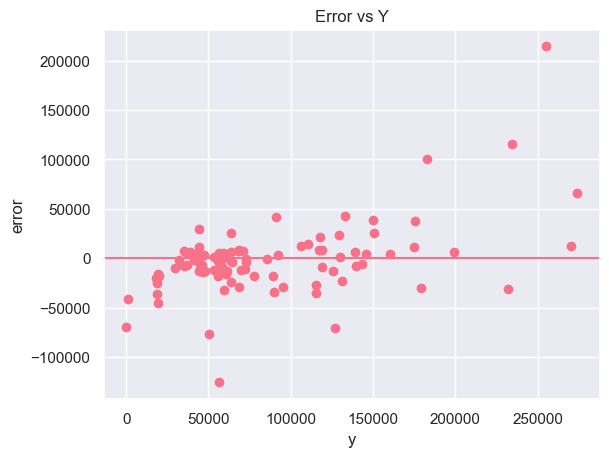

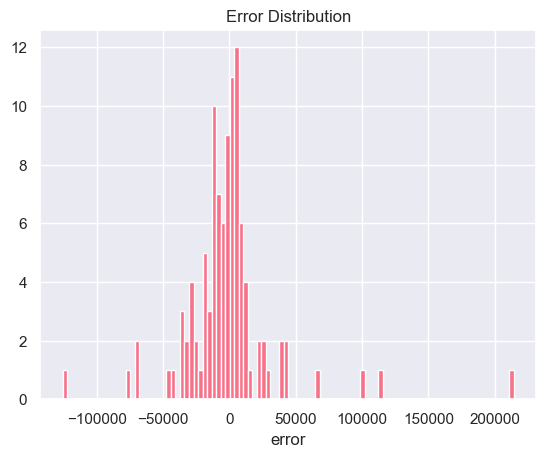

In [52]:
# Plots para visualizar errores
mp.yhat_vs_y(y_pred,y_test,save=True)
mp.error_vs_y(y_pred,y_test,save=True)
mp.error_distribution(y_pred,y_test,save=True)

#### Exportar modelo

In [57]:
# Entrenamos el modelo con todo el set de datos
pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LinearRegression())])

In [59]:
# Guardamos el modelo ya entrenado como .pkl para poder usarlo en el deployment
joblib.dump(pipeline, 'linear_reg_bsky.pkl')

['linear_reg_bsky.pkl']

# Linear Regression: weekly new users
Objetivo: predecir los nuevos usuarios de la semana próxima. En este caso trabajamos con muy pocos datos, solo un registro con datos agregados por semana.

### Dataset semanal
Preparamos el dataset con datos semanales.

In [135]:
df = pd.read_csv('final_dataset_bsky_news.csv')

In [136]:
df = pre.basic_proc_final_dataset(df)

In [137]:
df_weekly = pre.generate_weekly_df(df)

In [140]:
# Separamos las columnas de texto para aplicarles el impact_score
df_text_weekly = df_weekly.drop(columns = df_weekly._get_numeric_data().columns)

# Separamos las columnas que serán el resto de features del modelo
df_ft_weekly = df_weekly.drop(columns = df_text_weekly.columns)

### Feature Engineering para datos continuos
- PCA para las columnas de actividad.
- Series temporales: Lags (yesterday data for users, new users and activity score), Rolling Mean (7 day rolling mean data for new users and activity score), Diff.

In [144]:
df_ft_weekly = pre.activity_score_pca(df_ft_weekly)
df_ft_weekly = pre.temp_columns(df_ft_weekly, window = 4)

### Impact Score para las noticias
Sacamos el impact score de las noticias de 2025 para usarlo como una feature más del modelo.

In [ ]:
# 1. Pipeline para aplicar los diferentes componentes (solo 2025)
df_text_2025 = df_text_weekly.loc['01-01-2025':,:]
impact_score_array = isc.impact_score_pipeline.fit_transform(df_text_2025)

In [ ]:
# 2. Cargamos el modelo XGBoost pre-entrenado
xgb_model_weekly = joblib.load('impact_score_xgb_model_weekly.pkl')

In [13]:
# 3. Sacamos el impact_score de las noticias de 2025
impact_score_2025 = xgb_model_weekly.predict_proba(df_text_2025)[:,1]

In [14]:
# Unimos esta nueva feature al resto del dataframe

# Crear rango de fechas para el array actual
start_2025 = pd.to_datetime('2025-01-01')
end_2025 = pd.to_datetime('2025-04-07')
dates_2025 = pd.date_range(start=start_2025, end=end_2025)

# Crear el DataFrame con los datos
df_2025 = pd.DataFrame(data=impact_score_2025, index=dates_2025, columns=['impact_score'])

# Crear rango de fechas faltante (desde 2023-05-08 hasta 2024-12-31)
dates_missing = pd.date_range(start='2023-05-08', end='2024-12-31')
df_missing = pd.DataFrame(0, index=dates_missing, columns=['impact_score'])

# Concatenar ambos DataFrames
df_impact_score_2025 = pd.concat([df_missing, df_2025])

# Verificamos que todo esté ordenado por fecha
df_impact_score_2025 = df_impact_score_2025.sort_index()

In [15]:
# Concatenamos con el df completo
df_final_weekly = pd.concat([df_ft_weekly, df_impact_score_2025], axis = 1)

### Target: próxima semana
Nuestro objetivo es predecir los nuevos usuarios que habrá la próxima semana

In [152]:
df_final_weekly['target'] = df_final_weekly['new_users'].shift(-1)
df_final_weekly = df_final_weekly.fillna(0)

In [153]:
# Target
target = 'target'

# X y division
X = df_final_weekly.drop(columns=target)
y = df_final_weekly[target]

### Features del modelo
- **tot_users**: el total de usuarios agregado por día
- **new_users**: el total de nuevos usuarios diario
- **activity_score_pca**: principal components analysis (score de -1.7 a 8.7)
- **Impact Score**: impacto de las noticias en el crecimiento de la actividad en la red
- **Target**: nuevos usuarios del día siguiente

## Regression Model

#### Train-Test Split

In [313]:
total_reg = len(df_final_weekly.index)
test_size_reg = 0.22

total_test = round(total_reg*test_size_reg)
total_train = total_reg-total_test

total_test, total_train

(22, 79)

Fechas train : 2023-05-14 00:00:00 --- 2024-11-10 00:00:00  (n=79)
Fechas test  : 2024-11-17 00:00:00 --- 2025-04-13 00:00:00  (n=22)


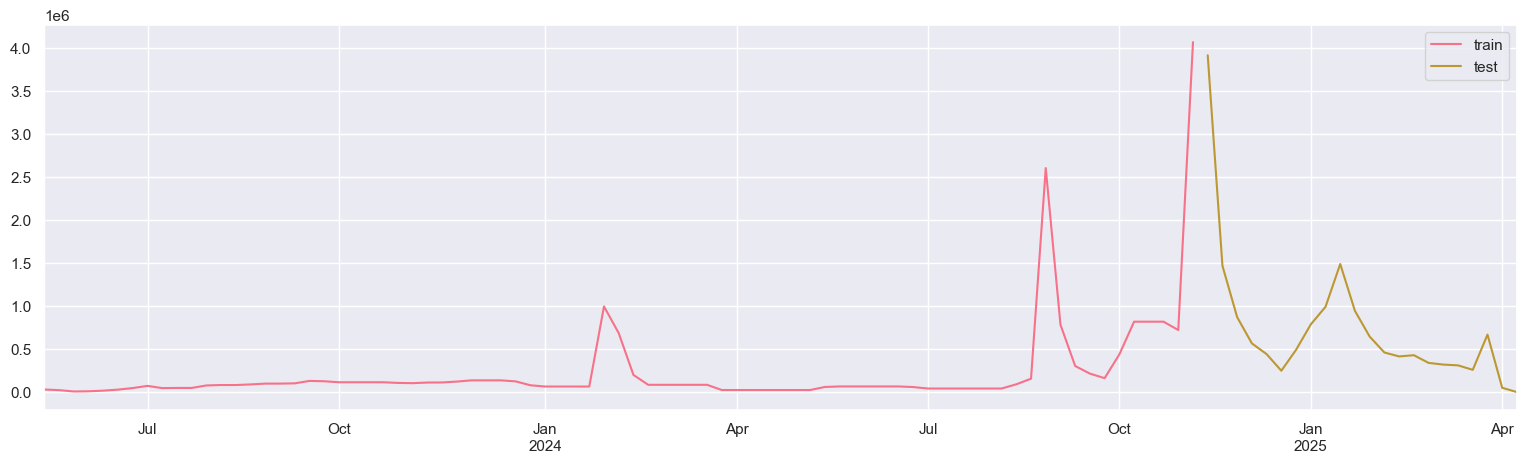

In [315]:
# Separación datos train-test
# Se usan los últimos *total_test días para testear el modelo
# ==============================================================================
steps = total_test
datos_train = df_final_weekly[:-steps]
datos_test  = df_final_weekly[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(19, 5))
datos_train[target].plot(ax=ax, label='train')
datos_test[target].plot(ax=ax, label='test')
ax.legend();

In [317]:
X_train = datos_train.drop(columns = target)
y_train = datos_train[target]

X_test = datos_test.drop(columns = target)
y_test = datos_test[target]

#### LinearRegression
Al trabajar con muy pocos datos nos encontramos con predicciones muy pobres para el conjunto de test. Buscamos posibles mejoras en el modelo.

In [353]:
# Definición del modelo
model_weekly = LinearRegression()

# Para escalar los datos
scaler = StandardScaler()

# Pipeline
pipeline_weekly = Pipeline([
    ('scaler', StandardScaler()),
    ('model', model_weekly)
])

In [365]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Métrica
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Alphas comunes
alphas = [0.01, 0.1, 1, 10, 100]

In [367]:
# Ridge
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
])
ridge_grid = {
    'model__alpha': alphas
}

# Lasso
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(max_iter=10000))
])
lasso_grid = {
    'model__alpha': alphas
}

# ElasticNet
enet_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', ElasticNet(max_iter=10000))
])
enet_grid = {
    'model__alpha': alphas,
    'model__l1_ratio': [0.1, 0.5, 0.9]  # mezcla entre Lasso y Ridge
}

# RandomForest (no necesita escalado)
rf_pipe = Pipeline([
    ('model', RandomForestRegressor(random_state=42))
])
rf_grid = {
    'model__n_estimators': [100],
    'model__max_depth': [None, 3, 5, 10]
}


In [369]:
modelos = {
    "Ridge": (ridge_pipe, ridge_grid),
    "Lasso": (lasso_pipe, lasso_grid),
    "ElasticNet": (enet_pipe, enet_grid),
    "RandomForest": (rf_pipe, rf_grid)
}

resultados = {}

for nombre, (pipe, grid) in modelos.items():
    print(f"🔍 Buscando mejor {nombre}...")
    gs = GridSearchCV(pipe, grid, scoring=mse_scorer, cv=5, n_jobs=-1)
    gs.fit(X_train, y_train)

    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = best_model.score(X_test, y_test)

    resultados[nombre] = {
        "Best Params": gs.best_params_,
        "Test RMSE": rmse,
        "Test R2": r2
    }

# Mostrar resultados ordenados por RMSE
print("\n📊 Resultados comparativos:")
for nombre, res in sorted(resultados.items(), key=lambda x: x[1]["Test RMSE"]):
    print(f"{nombre}: RMSE={res['Test RMSE']:.2f}, R²={res['Test R2']:.2f}, Params={res['Best Params']}")


🔍 Buscando mejor Ridge...
🔍 Buscando mejor Lasso...


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e+12, tolerance: 2.387e+09
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.199e+09, tolerance: 1.287e+08
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.119e+12, toler

🔍 Buscando mejor ElasticNet...
🔍 Buscando mejor RandomForest...

📊 Resultados comparativos:
Ridge: RMSE=1241811.58, R²=-1.46, Params={'model__alpha': 100}
ElasticNet: RMSE=1324880.69, R²=-1.80, Params={'model__alpha': 1, 'model__l1_ratio': 0.1}
RandomForest: RMSE=1717821.57, R²=-3.70, Params={'model__max_depth': 10, 'model__n_estimators': 100}
Lasso: RMSE=1755525.48, R²=-3.91, Params={'model__alpha': 100}


In [381]:
# Definición del modelo
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=100))
    ])

In [383]:
pipeline_ridge

Pipeline(steps=[('scaler', StandardScaler()), ('model', Ridge(alpha=100))])

In [385]:
# Entrenamos el modelo
pipeline_ridge.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('model', Ridge(alpha=100))])

In [387]:
# Predicciones sobre el conjunto de train
y_pred_train = pipeline_ridge.predict(X_train)
# Predicciones sobre el conjunto de prueba
y_pred = pipeline_ridge.predict(X_test)

# Evaluar el modelo train
mse = mean_squared_error(y_train, y_pred_train)
r2 = r2_score(y_train, y_pred_train)
rmse = np.sqrt(mse)

print('TRAIN')
print(f"  MSE: {mse:.2f}")
print(f"  R²: {r2:.2f}")
print(f"  RMSE: {rmse:.2f}")

# Evaluar el modelo test
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print('TEST')
print(f"  MSE: {mse:.2f}")
print(f"  R²: {r2:.2f}")
print(f"  RMSE: {rmse:.2f}")

TRAIN
  MSE: 209312627848.60
  R²: 0.33
  RMSE: 457506.97
TEST
  MSE: 1542096000508.01
  R²: -1.46
  RMSE: 1241811.58


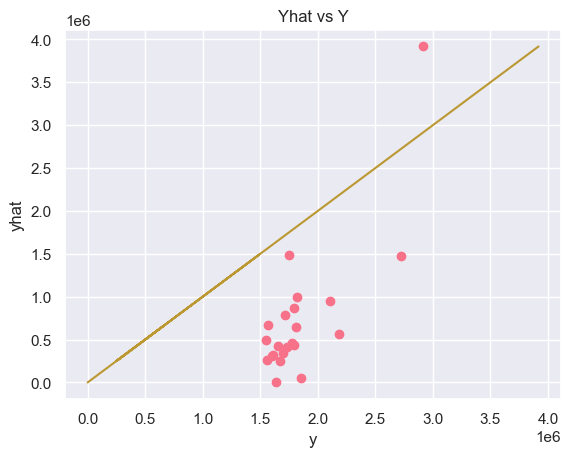

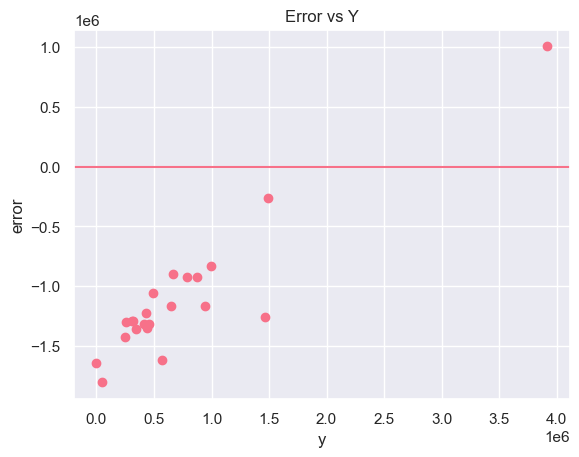

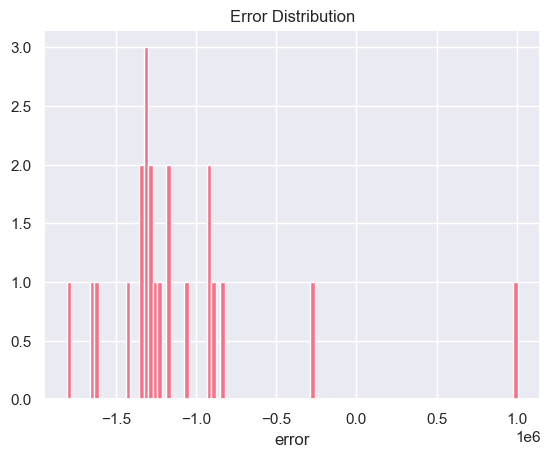

In [391]:
# Plots para visualizar errores
mp.yhat_vs_y(y_pred,y_test,save=True)
mp.error_vs_y(y_pred,y_test,save=True)
mp.error_distribution(y_pred,y_test,save=True)